In [ ]:
!pip install jsonlines
import jsonlines
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import TruncatedSVD
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, Flatten
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report




In [ ]:
# NLTK Türkçe stopwords'leri indirme
nltk.download('stopwords')
turkce_stopwords = set(stopwords.words('turkish'))



# Hakaret ve zorbalık içeren anahtar kelimeler listesi
hate_words = {'kötü', 'salak', 'aptal', 'nefret', 'çirkin', 'haksız', 'yalancı', 'amk', 'aq', 'manyak', 'köpek', 'gerizekalı'}

# Temizleme ve hakaret kelimelerini ağırlıklandırma fonksiyonu
def temizle_ve_agirliklandir(text):
    text = text.lower()  # Tüm harfleri küçük yapma
    text = re.sub(r"@\w+|https?://[A-Za-z0-9./]+", '', text)  # URL ve kullanıcı adı temizleme
    text = re.sub(r"[^a-zA-Z0-9ığüşöçİĞÜŞÖÇ\s]", '', text)  # Özel karakter temizleme

    # Kelimelere ayırma
    text_words = text.split()

    # Stopwords temizleme ve kelimelerin köklerine indirgenmesi
    filtered_words = [kelime for kelime in text_words if kelime not in turkce_stopwords]

    # Ekleri kaldırma (Türkçe ekleri ayıklamak için basit bir regex)
    filtered_words = [re.sub(r"(de|den|da|ki|mi|lar|ler)$", '', kelime) for kelime in filtered_words]

    # Tekrar eden kelimeleri kaldırma
    filtered_words = list(set(filtered_words))  # Set kullanarak tekrarları engelle

    # Hakaret kelimelerini daha fazla vurgulama
    for word in hate_words:
        if word in filtered_words:
            filtered_words += [word] * 5  # Hakaret kelimelerini 5 kat artır

    # Sonuç olarak düzenlenmiş metni döndürme
    filtered_text = ' '.join(filtered_words)
    return filtered_text

# Veri setini yükleme fonksiyonu
def load_data(filename):
    data = []
    with jsonlines.open(filename) as reader:
        for obj in reader:
            data.append(obj)
    return pd.DataFrame(data)

# Veri setini yükle
train_df = load_data('train.jsonlines')


# Temizlenmiş metin sütunlarını oluşturma
train_df_cleaned = train_df.copy()
train_df_cleaned["CLEAN_TEXT"] = train_df_cleaned["text"].map(lambda x: temizle_ve_agirliklandir(x))

# 'label' sütunundaki 'offensive' ve 'not-offensive' değerlerini 1 ve 0'a çevirme
train_df_cleaned['label'] = train_df_cleaned['label'].map({'offensive': 1, 'not-offensive': 0})

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!



Train DataFrame Head:
                                                text  label  \
0  @USER en güzel uyuyan insan ödülü jeon jungkoo...      0   
1  @USER Mekanı cennet olsun, saygılar sayın avuk...      0   
2  Kızlar aranızda kas yığını beylere düşenler ol...      0   
3  Biraz ders çalışayım. Tembellik ve uyku düşman...      0   
4  @USER Trezeguet yerine El Sharawy daha iyi olm...      0   

                                          CLEAN_TEXT  
0    ödülü güzel insan uyuyan gidiyor jungkooka jeon  
1  dilerim gün avukatımıziyi olsun saygı cennet s...  
2  aranız görüyorum yapmayın beylere aşkına kas o...  
3  biraz çalışayım uyku ders tembellik düşmanımızdır  
4              olmaz sharawy iyi el trezeguet yerine  

Train Missing Values:
text          0
label         0
CLEAN_TEXT    0
dtype: int64


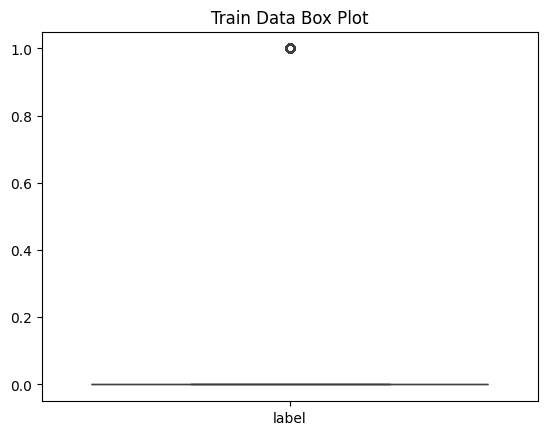

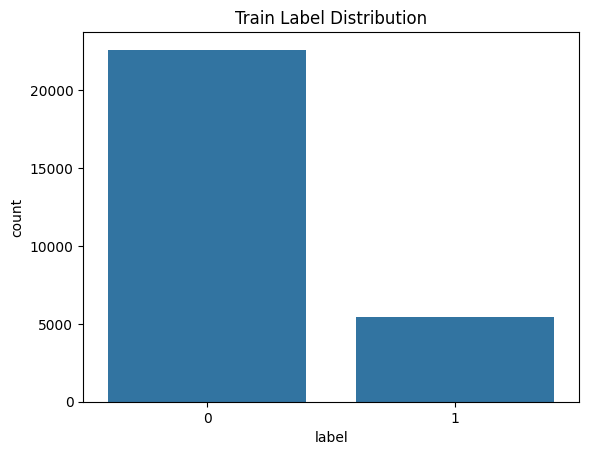

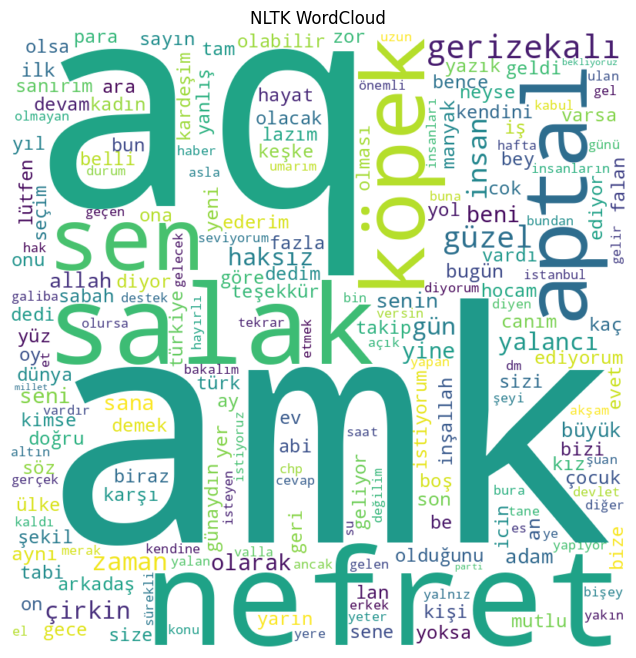

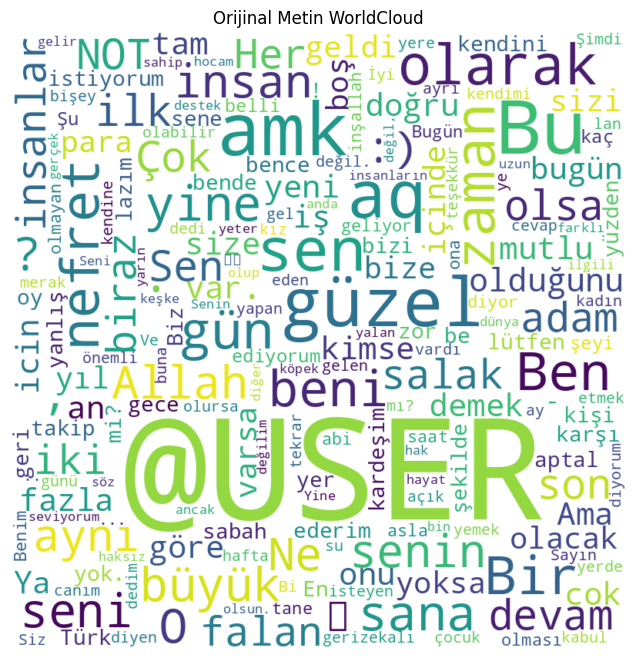

In [ ]:
# EDA - Veri Yapısı İnceleme
def eda(df, name):
    print(f"\n{name} DataFrame Head:")
    print(df.head())
    print(f"\n{name} Missing Values:")
    print(df.isnull().sum())

    sns.boxplot(data=df.select_dtypes(include=['float64', 'int64']))
    plt.title(f'{name} Data Box Plot')
    plt.show()

    sns.countplot(x='label', data=df)
    plt.title(f'{name} Label Distribution')
    plt.show()

# EDA uygulama
eda(train_df_cleaned, 'Train')

# Hakaret kelimelerini belirgin yapmak için ağırlıklandırma fonksiyonu
def generate_wordcloud_with_weights(text_data, title):
    custom_stopwords = turkce_stopwords.union({
        'bir', 'bu', 'de', 've', 'ile', 'ben', 'ama', 'çok', 'hiç', 'şu', 'ne', 'neden', 'gibi', 'daha', 'ya', 'ya da',
        'her', 'hiçbir', 'bunu', 'şey', 'oldu', 'olmaz', 'bu kadar', 'kadar', 'sonra', 'önce', 'şimdi',
        'dönem', 'şu an', 'bunu', 'onlar', 'yok', 'oluyor', 'olan', 'şimdiye', 'belki', 'öyle', 'için', 'ki',
        'ama', 'bile', 'hep', 'kim', 'nasıl', 'işte', 'başka', 'onun', 'sizin', 'bizim', 'bunlar', 'arasında',
        'bununla', 'işte', 'tamam', 'sadece', 'göstermek', 'birçok', 'katkı', 'bunu', 'bile', 'nerede', 'en',
        'değil', 'olmak', 'hepsi', 'neden', 'hangi', 'arada', 'çoğu', 'ama', 'sizin', 'biz', 'onlar', 'ama',
        'çünkü', 'şimdi', 'henüz', 'çok', 'daha', 'gerçekten', 'sadece', 'şu', 'ile', 'gibi', 'bunu', 'yani',
        'hadi', 'burası', 'gösterdi', 'göstermek', 'benim', 'onlar', 'hadi', 'ki', 'bak', 'belirli', 'şu kadar',
        'hiçbir zaman', 'bazen', 'gerek', 'bazı', 'için', 'yerine', 'sonunda', 'arasında', 'gibi', 'daha çok',
        'çünkü', 'neden', 'isterseniz', 'neredeyse', 'zaten', 'genellikle', 'aslında', 'henüz', 'neden', 'bunu',
        'kendisi', 'bu yüzden', 'tek', 'birisi', 'birkaç', 'çokça', 'kendi', 'şeyler', 'sonuçta', 'gerçekten',
        'şimdiye kadar', 'öncelikle', 'yapmak', 'olduğu', 'özellikle', 'sadece', 'işte', 'bütün', 'onlarca', 'birde',
        'herkes', 'herhangi', 'tartışmasız', 'belki', 'ya da', 'kesinlikle', 'hemen', 'şunlar', 'bunlar', 'en son',
        'şu şekilde', 'her zaman', 'gerekli', 'daha önce', 'genellikle', 'zaman zaman', 'en iyi', 'çok fazla',
        'hiçbir şekilde', 'bazı şeyler', 'katılıyorum', 'bu kadar', 'her biri', 'sonuç olarak', 'bu da', 'bazı',
        'olabilirdi', 'işin gerçeği', 'en büyük', 'göstermek için', 'çok fazla', 'hepsi', 'tek bir', 'gerçekten',
        'işin sırrı', 'var', 'kötü', 'bi', 'böyle', 'mi', 'iyi', 'artık', 'bana', 'olsun', 'hala', 'olur', 'olmuş',
        'yok', 'bunun', 'i', 'e', '3', '1', '2', '4', '5', '6', '7', '10', '9', '8', 'a', 'böy', '10', '20', '15'
    })

    # Kelimelerin sıklığını hesaplayın
    word_frequencies = {}
    for word in ' '.join(text_data).split():
        if word not in custom_stopwords:
            if word in word_frequencies:
                word_frequencies[word] += 1
            else:
                word_frequencies[word] = 1

    # Hakaret kelimeleri için özel ağırlıklandırma
    for word in hate_words:
        if word in word_frequencies:
            word_frequencies[word] *= 5  # Hakaret kelimelerine 5 kat ağırlık ekleyin

    # WordCloud oluşturun
    wordcloud = WordCloud(stopwords=custom_stopwords, width=800, height=800, background_color='white').generate_from_frequencies(word_frequencies)

    # WordCloud görüntüsü
    plt.figure(figsize=(8, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title)
    plt.show()

# Wordcloud grafiğini oluştur
generate_wordcloud_with_weights(train_df_cleaned['CLEAN_TEXT'], 'Train Data WordCloud')

In [ ]:
# Model oluşturma ve sınıflandırma
X = train_df_cleaned['CLEAN_TEXT']  # 'CLEAN_TEXT' metin verisi içeren sütun
y = train_df_cleaned['label']       # 'label' hedef etiketi içeren sütun

# Eğitim ve test verilerini ayıralım
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# TF-IDF hesaplama ve her tweet için kelimelerinin ağırlıklarını elde etme fonksiyonu
def calculate_tfidf_weights(df):
    vectorizer = TfidfVectorizer(max_features=5000)  # max_features belirleyerek sadece en sık kullanılan 5000 kelimeyi alıyoruz
    tfidf_matrix = vectorizer.fit_transform(df['CLEAN_TEXT'])

    # Kelimelerin adlarını alalım
    feature_names = vectorizer.get_feature_names_out()

    # Sonuçları bir DataFrame olarak düzenleyelim
    tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)

    return tfidf_df, vectorizer  # vectorizer'ı da döndürelim

# TRAIN veri seti için TF-IDF hesaplama
train_tfidf, vectorizer = calculate_tfidf_weights(train_df_cleaned)

# TF-IDF değerlerine göre her tweetin ağırlıklarını görmek için bir örnek yazdırabiliriz
print("Train Data TF-IDF Head:")
print(train_tfidf.head())

Train Data TF-IDF Head:
    10  100  1000  10bin   11   12   13   14   15  150  ...  şizofren  şok  \
0  0.0  0.0   0.0    0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...       0.0  0.0   
1  0.0  0.0   0.0    0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...       0.0  0.0   
2  0.0  0.0   0.0    0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...       0.0  0.0   
3  0.0  0.0   0.0    0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...       0.0  0.0   
4  0.0  0.0   0.0    0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...       0.0  0.0   

   şov  şuan  şubat  şuna  şunu  şöyle  şükür  şüphe  
0  0.0   0.0    0.0   0.0   0.0    0.0    0.0    0.0  
1  0.0   0.0    0.0   0.0   0.0    0.0    0.0    0.0  
2  0.0   0.0    0.0   0.0   0.0    0.0    0.0    0.0  
3  0.0   0.0    0.0   0.0   0.0    0.0    0.0    0.0  
4  0.0   0.0    0.0   0.0   0.0    0.0    0.0    0.0  

[5 rows x 5000 columns]



Logistic Regression Modeli Başlatılıyor...
Logistic Regression Accuracy on Training Data: 0.8577678571428572
Logistic Regression Classification Report on Training Data:
              precision    recall  f1-score   support

           0       0.85      0.99      0.92     18072
           1       0.92      0.29      0.44      4328

    accuracy                           0.86     22400
   macro avg       0.89      0.64      0.68     22400
weighted avg       0.87      0.86      0.83     22400

Logistic Regression Accuracy on Test Data: 0.8491071428571428
Logistic Regression Classification Report on Test Data:
              precision    recall  f1-score   support

           0       0.85      0.99      0.91      4521
           1       0.84      0.27      0.41      1079

    accuracy                           0.85      5600
   macro avg       0.84      0.63      0.66      5600
weighted avg       0.85      0.85      0.82      5600

Confusion Matrix for Training Data (Logistic Regression):


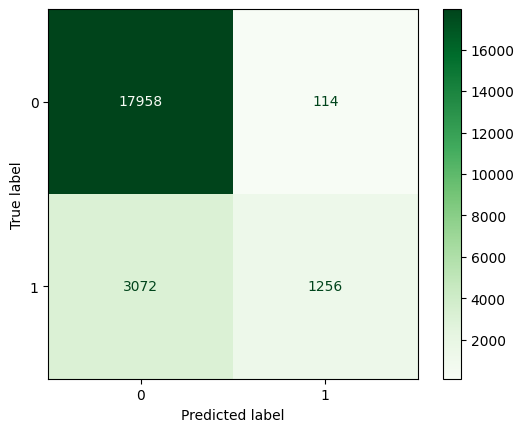

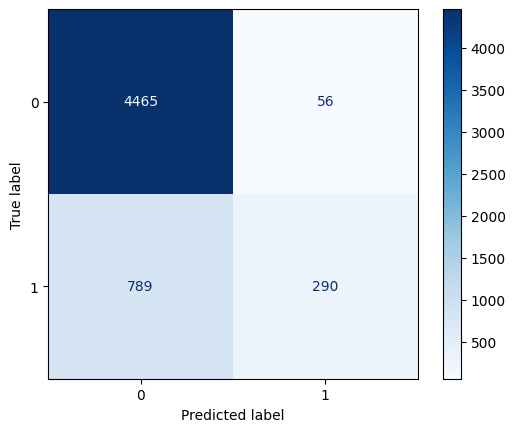

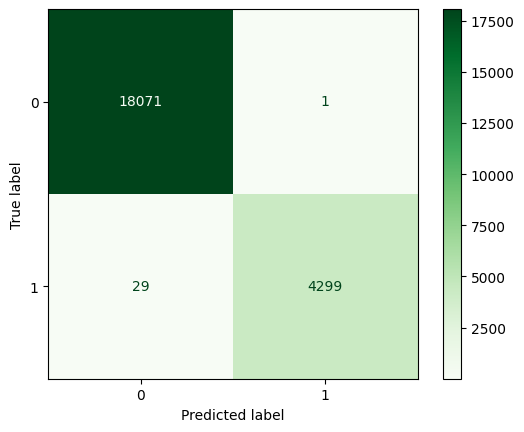

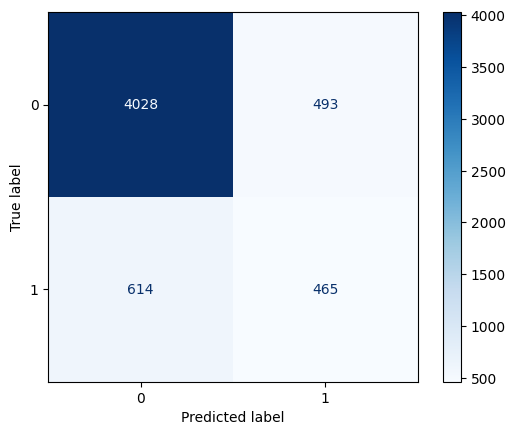

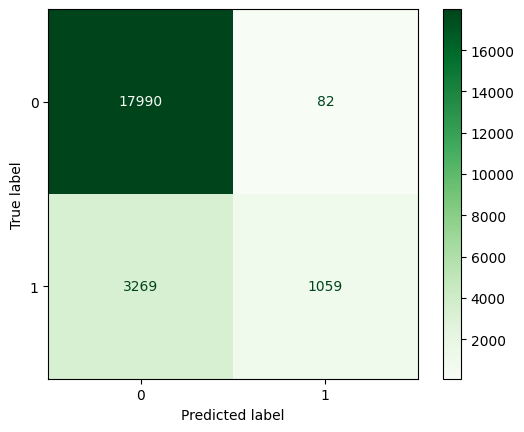

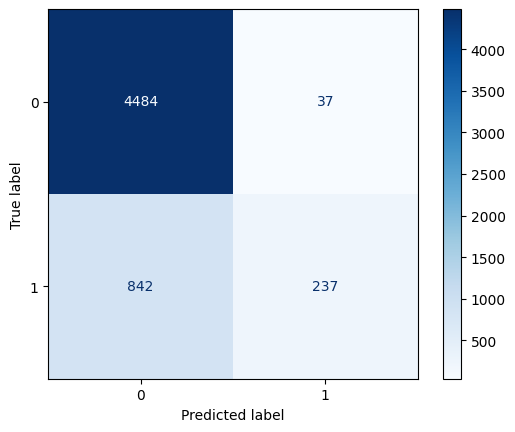

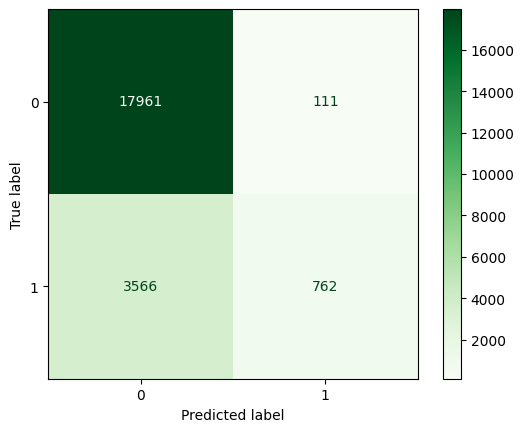

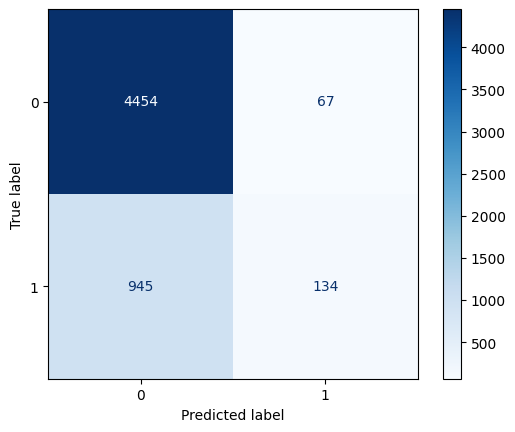

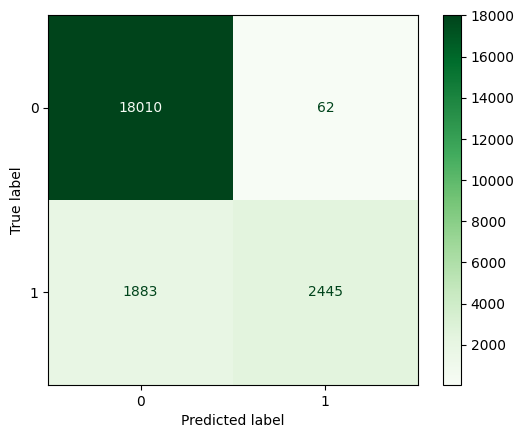

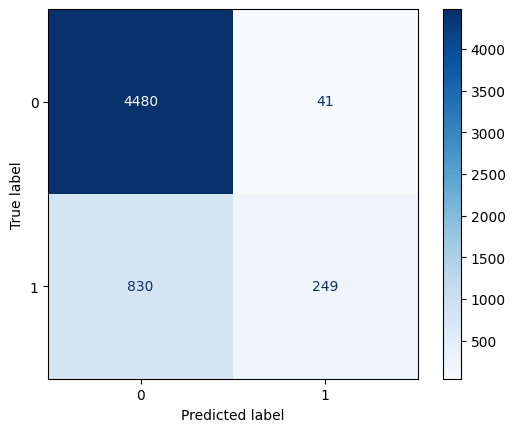

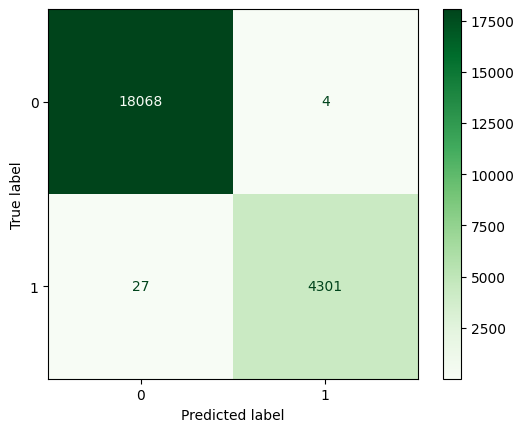

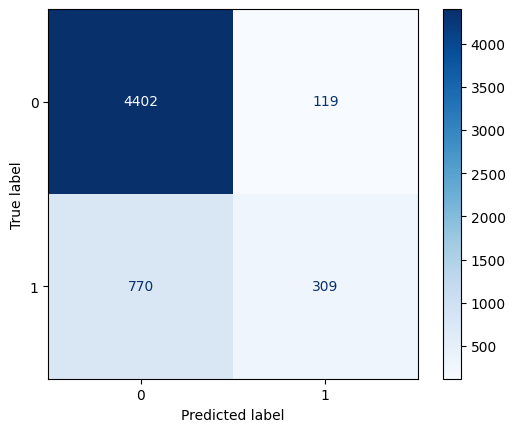

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# Modelleri tanımlama
models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Naive Bayes': MultinomialNB(),
    'K-Nearest Neighbours': KNeighborsClassifier(),
    'Support Vector Machines': SVC(),
    'Random Forest': RandomForestClassifier()
}

# Eğitim ve test verisi ile her modeli değerlendir
for model_name, model in models.items():
    print(f"\n{model_name} Modeli Başlatılıyor...")

    # Pipelines kullanarak modeli kuruyoruz
    model_pipeline = make_pipeline(vectorizer, model)

    # Eğitim verisi üzerinde modeli eğitelim
    model_pipeline.fit(X_train, y_train)

    # Eğitim verisi üzerinde tahmin yapalım
    y_pred_train = model_pipeline.predict(X_train)

    # Test verisi üzerinde tahmin yapalım
    y_pred_test = model_pipeline.predict(X_test)

    # Eğitim verisi üzerindeki sonuçları değerlendirme
    print(f"{model_name} Accuracy on Training Data: {accuracy_score(y_train, y_pred_train)}")
    print(f"{model_name} Classification Report on Training Data:")
    print(classification_report(y_train, y_pred_train))

    # Test verisi üzerindeki sonuçları değerlendirme
    print(f"{model_name} Accuracy on Test Data: {accuracy_score(y_test, y_pred_test)}")
    print(f"{model_name} Classification Report on Test Data:")
    print(classification_report(y_test, y_pred_test))

    # Eğitim verisi için Confusion Matrix oluşturma
    cm_train = confusion_matrix(y_train, y_pred_train)
    disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=model_pipeline.classes_)
    print(f"Confusion Matrix for Training Data ({model_name}):")
    disp_train.plot(cmap='Greens')

    # Test verisi için Confusion Matrix oluşturma
    cm_test = confusion_matrix(y_test, y_pred_test)
    disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=model_pipeline.classes_)
    print(f"Confusion Matrix for Test Data ({model_name}):")
    disp_test.plot(cmap='Blues')


TF-IDF Data Head (Top 20 Features):
     10  abi  adam     allah       amk   an     ancak  aptal   aq       ara  \
0   0.0  0.0   0.0  0.000000  0.000000  0.0  0.000000    0.0  0.0  0.000000   
1   0.0  0.0   0.0  0.000000  0.000000  0.0  0.000000    0.0  0.0  0.000000   
2   0.0  0.0   0.0  0.528247  0.000000  0.0  0.000000    0.0  0.0  0.000000   
3   0.0  0.0   0.0  0.000000  0.000000  0.0  0.000000    0.0  0.0  0.000000   
4   0.0  0.0   0.0  0.000000  0.000000  0.0  0.000000    0.0  0.0  0.000000   
5   0.0  0.0   0.0  0.000000  0.000000  0.0  0.000000    0.0  0.0  0.000000   
6   0.0  0.0   0.0  0.000000  0.000000  0.0  0.000000    0.0  0.0  0.000000   
7   0.0  0.0   0.0  0.000000  0.000000  0.0  0.000000    0.0  0.0  0.000000   
8   0.0  0.0   0.0  0.000000  0.000000  0.0  0.000000    0.0  0.0  0.000000   
9   0.0  0.0   0.0  0.000000  0.000000  0.0  0.717703    0.0  0.0  0.000000   
10  0.0  0.0   0.0  0.000000  0.980499  0.0  0.000000    0.0  0.0  0.000000   
11  0.0  0.0   

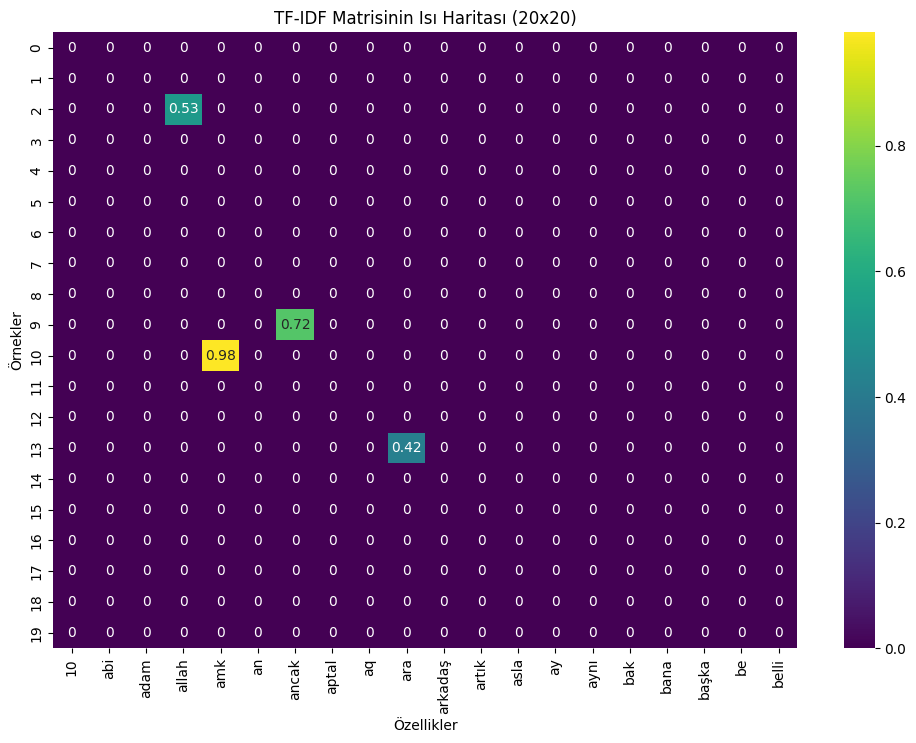

SVD ile 3 Boyuta İndirgenmiş Verinin İlk 5 Satırı:
[[ 0.08861019 -0.02789808 -0.03128804]
 [ 0.06597733 -0.02072994 -0.0253113 ]
 [ 0.03199994 -0.00879361 -0.01043834]
 [ 0.02721961 -0.00704249 -0.01051657]
 [ 0.08207023 -0.02505131 -0.01605858]]


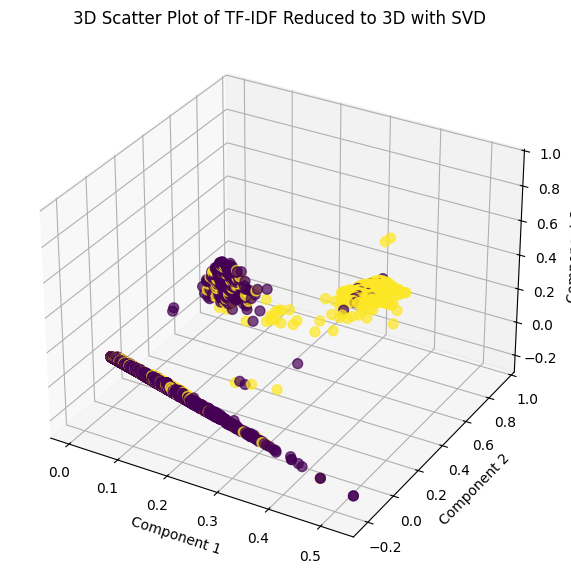

SVD ile 2 Boyuta İndirgenmiş Verinin İlk 5 Satırı:
[[ 0.08887162 -0.02827111]
 [ 0.06555297 -0.02074232]
 [ 0.03192289 -0.00884935]
 [ 0.02719242 -0.00713938]
 [ 0.08186681 -0.02590411]]


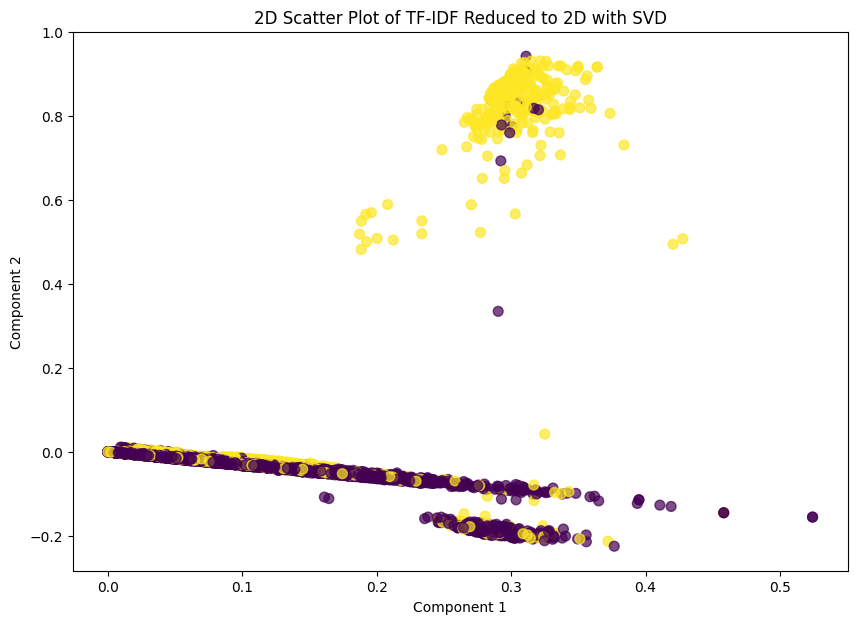

In [ ]:
# --- Görselleştirme Kısmı ---

# 400 en sık kullanılan kelimeyle yeni bir TF-IDF hesaplama
tfidf_vectorizer = TfidfVectorizer(max_features=200)
tfidf_matrix = tfidf_vectorizer.fit_transform(train_df_cleaned['CLEAN_TEXT'])

# TF-IDF tablosunu DataFrame olarak görselleştirme
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
print("\nTF-IDF Data Head (Top 20 Features):")
print(tfidf_df.iloc[:20, :20])

# 20x20'lik bir TF-IDF matrisi parçası seçme
tfidf_sample_df = tfidf_df.iloc[:20, :20]

# Isı haritasını çizdirme
plt.figure(figsize=(12, 8))
sns.heatmap(tfidf_sample_df, cmap="viridis", annot=True, cbar=True)
plt.title("TF-IDF Matrisinin Isı Haritası (20x20)")
plt.xlabel("Özellikler")
plt.ylabel("Örnekler")
plt.show()

# --- 3 Boyutlu SVD Uygulaması ---

# TF-IDF matrisini 3 boyuta indirmek için TruncatedSVD kullanıyoruz
def apply_svd_to_tfidf(tfidf_matrix, n_components=3):
    svd = TruncatedSVD(n_components=n_components)
    svd_matrix = svd.fit_transform(tfidf_matrix)
    return svd_matrix, svd

# TF-IDF hesaplama ve 3 boyutlu SVD'yi uygulama
tfidf_matrix = vectorizer.fit_transform(train_df_cleaned['CLEAN_TEXT'])
svd_matrix, svd = apply_svd_to_tfidf(tfidf_matrix)

# SVD ile indirgenmiş verinin ilk 5 satırını yazdıralım
print("SVD ile 3 Boyuta İndirgenmiş Verinin İlk 5 Satırı:")
print(svd_matrix[:5])

# --- Görselleştirme Kısmı ---

# SVD sonucu 3 boyutlu veri ile scatter plot çizme
# SVD sonuçlarını bir DataFrame'e dönüştürme
svd_df = pd.DataFrame(svd_matrix, columns=[f"Component {i+1}" for i in range(svd_matrix.shape[1])])

# 3D scatter plot çizme
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot için X, Y, Z eksenlerini seçme
x = svd_df['Component 1']
y = svd_df['Component 2']
z = svd_df['Component 3']

# Scatter plot oluşturma
ax.scatter(x, y, z, c=train_df_cleaned['label'], cmap='viridis', s=50, alpha=0.7)

# Başlık ve etiketler
ax.set_title('3D Scatter Plot of TF-IDF Reduced to 3D with SVD')
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')

plt.show()

# --- 2 Boyutlu SVD Uygulaması ---

# TF-IDF matrisini 2 boyuta indirmek için TruncatedSVD kullanıyoruz
def apply_svd_to_tfidf_2d(tfidf_matrix, n_components=2):
    svd = TruncatedSVD(n_components=n_components)
    svd_matrix = svd.fit_transform(tfidf_matrix)
    return svd_matrix, svd

# TF-IDF hesaplama ve 2 boyutlu SVD'yi uygulama
tfidf_matrix = vectorizer.fit_transform(train_df_cleaned['CLEAN_TEXT'])
svd_matrix_2d, svd_2d = apply_svd_to_tfidf_2d(tfidf_matrix)

# SVD ile indirgenmiş verinin ilk 5 satırını yazdıralım
print("SVD ile 2 Boyuta İndirgenmiş Verinin İlk 5 Satırı:")
print(svd_matrix_2d[:5])

# --- Görselleştirme Kısmı ---

# SVD sonucu 2 boyutlu veri ile scatter plot çizme
# SVD sonuçlarını bir DataFrame'e dönüştürme
svd_df_2d = pd.DataFrame(svd_matrix_2d, columns=[f"Component {i+1}" for i in range(svd_matrix_2d.shape[1])])

# 2D scatter plot çizme
plt.figure(figsize=(10, 7))
plt.scatter(svd_df_2d['Component 1'], svd_df_2d['Component 2'], c=train_df_cleaned['label'], cmap='viridis', s=50, alpha=0.7)

# Başlık ve etiketler
plt.title('2D Scatter Plot of TF-IDF Reduced to 2D with SVD')
plt.xlabel('Component 1')
plt.ylabel('Component 2')

plt.show()

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


350/350 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.8090 - loss: 0.4738 - val_accuracy: 0.8461 - val_loss: 0.3822
Epoch 2/5
350/350 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8772 - loss: 0.3163 - val_accuracy: 0.8211 - val_loss: 0.4150
Epoch 3/5
350/350 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9321 - loss: 0.1956 - val_accuracy: 0.8193 - val_loss: 0.5211
Epoch 4/5
350/350 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9663 - loss: 0.1036 - val_accuracy: 0.8134 - val_loss: 0.6664
Epoch 5/5
350/350 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9799 - loss: 0.0620 - val_accuracy: 0.8105 - val_loss: 0.7967
700/700 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
MLP Model Accuracy on Training Data: 0.9891071428571429
MLP Model Classification Report on Training Data:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     18072
           1       0.98      0.96      0.97      4328

    accuracy           

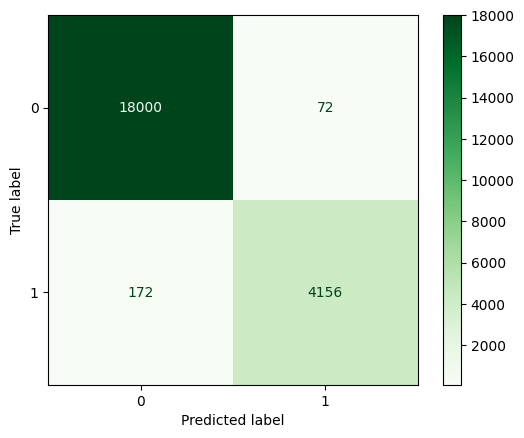

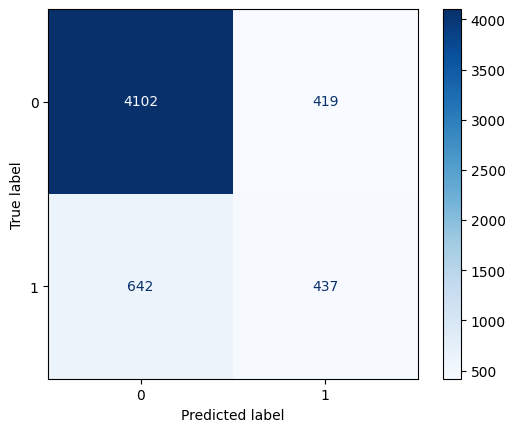

In [ ]:
# Gerekli kütüphaneleri ekliyoruz
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam

# MLP modelini eklemeden önce metin verisini Tokenizer ile işleyelim
tokenizer = Tokenizer(num_words=5000)  # En fazla 5000 kelimeyi dikkate alalım
tokenizer.fit_on_texts(train_df_cleaned['CLEAN_TEXT'])

# Veriyi sayısal dizilere dönüştürelim
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Dizileri sabit uzunlukta olacak şekilde pad edelim
max_length = 100  # Her örneğin uzunluğunu 100 kelimeye eşitleyelim
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length)


# MLP modelini oluşturma
def create_mlp_model(input_dim):
    model = Sequential()
    model.add(Embedding(input_dim=input_dim, output_dim=128, input_length=max_length))  # Embedding katmanı
    model.add(Flatten())  # Düzleştirme katmanı
    model.add(Dense(128, activation='relu'))  # Gizli katman
    model.add(Dropout(0.5))  # Dropout katmanı
    model.add(Dense(1, activation='sigmoid'))  # Çıkış katmanı (binary sınıflandırma)

    # Modeli derleyelim
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

    return model


# Modeli oluşturma
input_dim = len(tokenizer.word_index) + 1  # Tokenizer'ın oluşturduğu kelime sözlüğü büyüklüğü
mlp_model = create_mlp_model(input_dim)

# Modeli eğitme
mlp_model.fit(X_train_pad, y_train, epochs=5, batch_size=64, validation_data=(X_test_pad, y_test))

# Eğitim verisi üzerinde tahmin yapma
y_pred_train_mlp = (mlp_model.predict(X_train_pad) > 0.5).astype('int32')

# Test verisi üzerinde tahmin yapma
y_pred_test_mlp = (mlp_model.predict(X_test_pad) > 0.5).astype('int32')

# Eğitim verisi üzerindeki sonuçları değerlendirme
print(f"MLP Model Accuracy on Training Data: {accuracy_score(y_train, y_pred_train_mlp)}")
print(f"MLP Model Classification Report on Training Data:")
print(classification_report(y_train, y_pred_train_mlp))

# Test verisi üzerindeki sonuçları değerlendirme
print(f"MLP Model Accuracy on Test Data: {accuracy_score(y_test, y_pred_test_mlp)}")
print(f"MLP Model Classification Report on Test Data:")
print(classification_report(y_test, y_pred_test_mlp))


# Eğitim verisi için Confusion Matrix oluşturma
cm_train = confusion_matrix(y_train, y_pred_train_mlp)
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=[0, 1])
print("Confusion Matrix for Training Data:")
disp_train.plot(cmap='Greens')  # Eğitim için yeşil tonları

# Test verisi için Confusion Matrix oluşturma
cm_test = confusion_matrix(y_test, y_pred_test_mlp)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=[0, 1])
print("Confusion Matrix for Test Data:")
disp_test.plot(cmap='Blues')  # Test için mavi tonları
